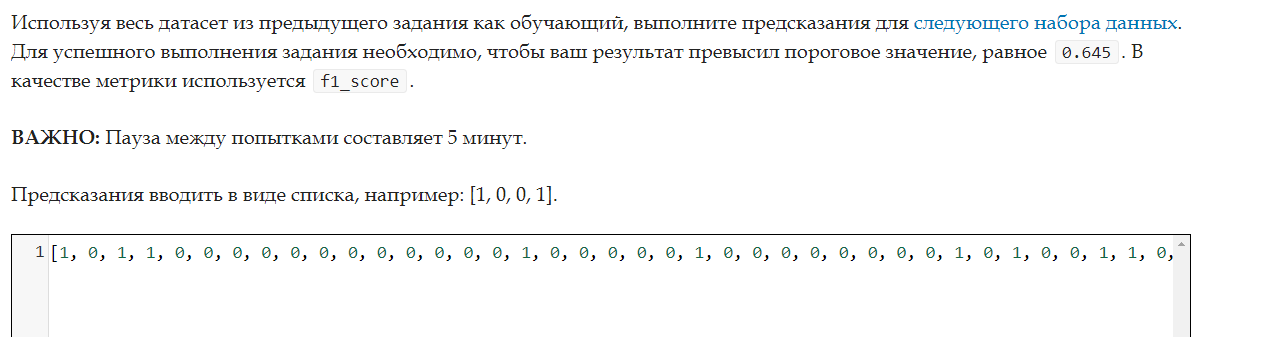

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
import category_encoders as ce

# Читаем
data_train = pd.read_csv('Data/adult_data_train.csv')
data_reserved = pd.read_csv('Data/adult_data_reserved.csv')

# Заполняем пропуски самым часто встречающим значением
data_train_cleaned = data_train[data_train != '?'].fillna(data_train.mode().iloc[0])
data_reserved_cleaned = data_reserved[data_reserved != '?'].fillna(data_reserved.mode().iloc[0])

# разделяем на предикторы и отклик
Y_train = data_train_cleaned[['label']]
X_train = data_train_cleaned.drop(['label'], axis=1)
X_test = data_reserved_cleaned.copy()


# разделяем на категориальные и метрические предикторы
mask = X_train.dtypes.values==object

x_train_mask = X_train[X_train.columns[mask]] # категориальные признаки
x_train_not_mask = X_train[X_train.columns[~mask]] # некатегориальные признаки
x_test_mask = X_test[X_test.columns[mask]]
x_test_not_mask = X_test[X_test.columns[~mask]]


# модификация категориальных признаков
te = ce.target_encoder.TargetEncoder(cols=x_train_mask.columns)
x_train_mask_ce = te.fit_transform(x_train_mask, Y_train)
x_train_mask_ce_final = pd.concat([x_train_mask_ce, x_train_not_mask], axis=1)
x_test_mask_ce = te.transform(x_test_mask)
x_test_mask_ce_final = pd.concat([x_test_mask_ce, x_test_not_mask], axis=1)

# масштабируем разбиваем обучаем и оцениваем
# масштабируем
scaler = MinMaxScaler()
x_train_mask_ce_final_scaled = pd.DataFrame(scaler.fit_transform(x_train_mask_ce_final), columns=x_train_mask_ce_final.columns)
x_test_mask_ce_final_scaled = pd.DataFrame(scaler.transform(x_test_mask_ce_final), columns=x_test_mask_ce_final.columns)


# определяем наилучшее расстояние и количество соседей
parameter_grid = {
    'n_neighbors': np.arange(2,10,1),
    'p': [1, 2, 3]
}

grid_searcher = GridSearchCV(estimator=KNeighborsClassifier(),
                             param_grid=parameter_grid,
                             cv=5,
                             scoring='f1',
                             n_jobs=-1
                             )

grid_searcher.fit(x_train_mask_ce_final, Y_train)

print(grid_searcher.best_params_)
print(grid_searcher.best_score_)
k = grid_searcher.best_params_['n_neighbors']
p = grid_searcher.best_params_['p']

model = KNeighborsClassifier(n_neighbors=7, p=2)
model.fit(x_train_mask_ce_final_scaled, Y_train)

predictions = model.predict(x_test_mask_ce_final_scaled)
print(predictions.tolist())